*First compiled: May 1, 2017.*

# DPT for hematopoiesis in mouse [(Moignard *et al.*, 2015)](http://dx.doi.org/10.1038/nbt.3154)

The following analysis has been published by [Haghverdi *et al.*, Nat. Meth. (2016)](http://dx.doi.org/10.1038/nmeth.3971) together with a Matlab implementation of Diffusion Pseudotime. The data is from [Moignard *et al.*, Nat. Biotechn. (2015)](http://dx.doi.org/10.1038/nbt.3154).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.4 on 2017-12-24 06:30.
Dependencies: numpy==1.13.3 scipy==0.19.1 pandas==0.21.0 scikit-learn==0.18 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.5.2+274.g35181a7 


This is single-cell qPCR data. It's already on a logrithmic scale and pretty low-dimensional. We do not have to perform extensive preprocessing.

1. Filter out a few genes.
2. Choose a 'root cell'.                                                                                                                                                           
3. Define groupnames by inspecting cellnames.                                                                                                                                    

In [2]:
filename = 'data/moignard15/nbt.3154-S3.xlsx'
# the url is used to download the file if it's not there yet
backup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'
adata = sc.read(filename, sheet='dCt_values.txt', cache=True, backup_url=backup_url)
# filter out genes as done by Haghverdi et al. (2016)
gene_subset = ~np.in1d(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])
# get a new AnnData object retain non-removed genes
adata = adata[:, gene_subset]
# choose root cell as in Haghverdi et al. (2016)
adata.uns['iroot'] = 532  # note that in Matlab/R, counting starts at 1
# annotate with Moignard et al. (2015) experimental cell groups
groups_names = ['HF', 'NP', 'PS', '4SG', '4SFG']
# annotate each sample/cell
adata.obs['exp_groups'] = [
    next(gname for gname in groups_names if sname.startswith(gname))
    for sname in adata.obs_names]
# make this a categorical column in the dataframe
adata.obs['exp_groups'] = pd.Categorical(adata.obs['exp_groups'],
                                         categories=groups_names)
# set the colors of names in "groups"
adata.uns['exp_groups_colors'] = ['#D7A83E', '#7AAE5D', '#497ABC', '#AF353A', '#765099']

Compute branchings and diffusion pseudotime using DPT.

In [5]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=5, knn=False)

performing Diffusion Pseudotime analysis
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 5 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.0000017881  0.9924937487  0.973900497   0.8865169287  0.8607167006
      0.8255124688  0.7805156112  0.7599624991  0.7338711619  0.7300988436]
    detect 1 branching
    do not consider groups with less than 39 points for splitting
    branching 1: split group 0
    finished (0:00:04.386) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


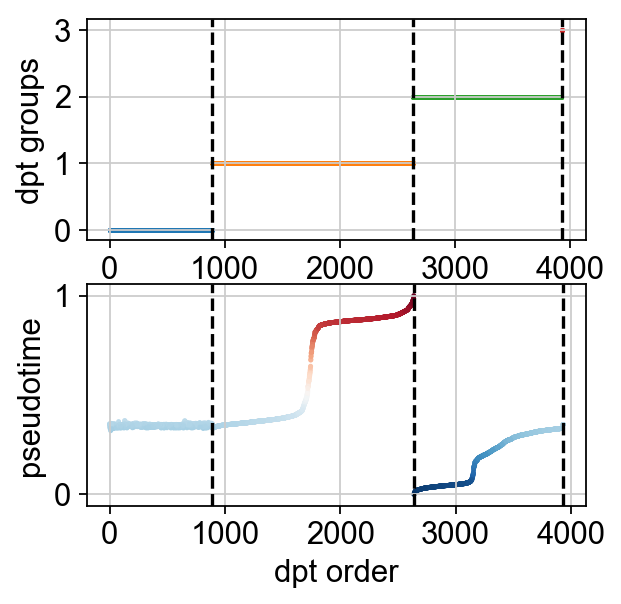

In [6]:
sc.pl.dpt_groups_pseudotime(adata)

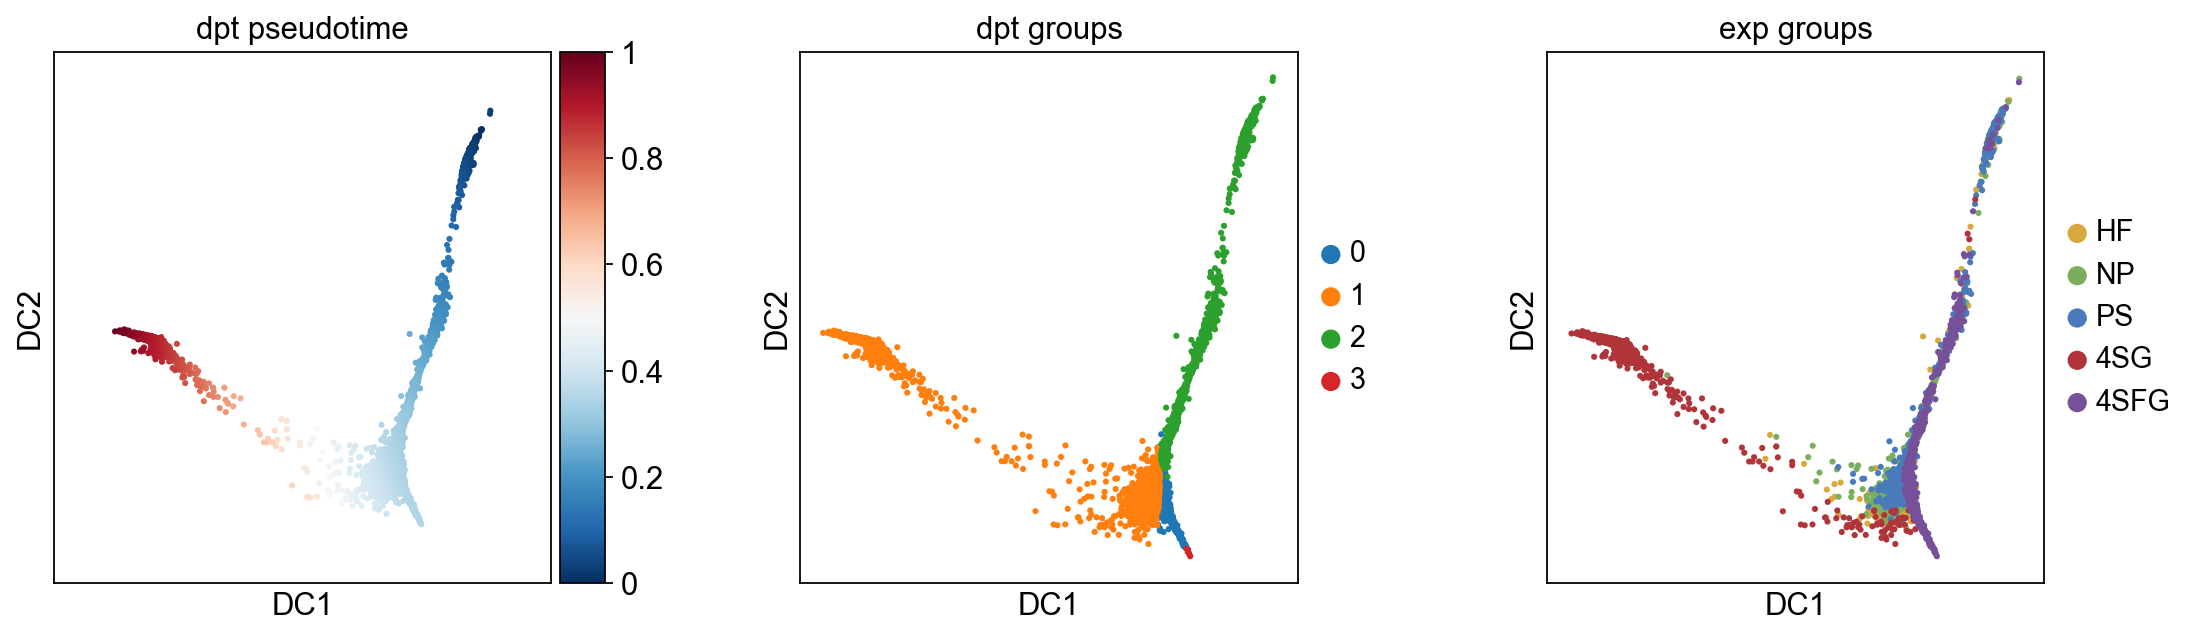

In [7]:
axs = sc.pl.scatter(adata, basis='diffmap',
                    color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'])

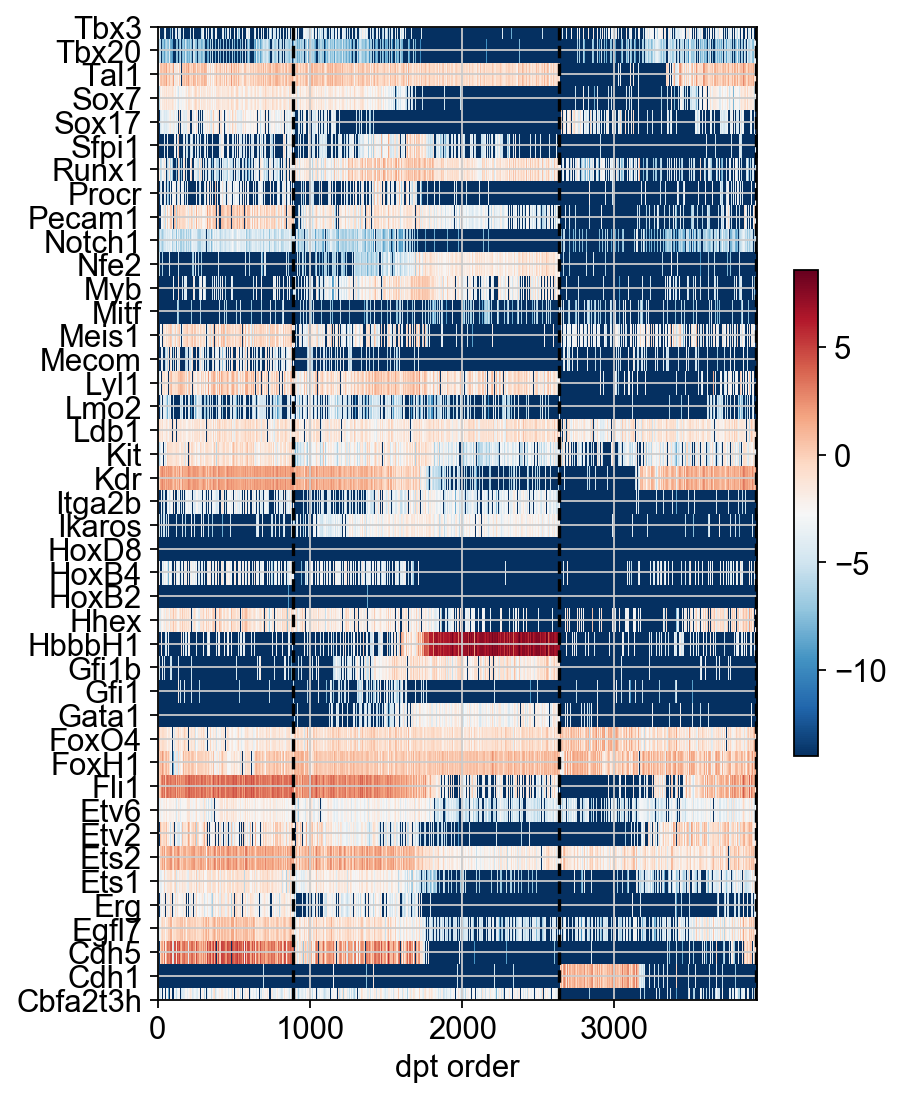

In [8]:
sc.pl.dpt_timeseries(adata)

Let us annotate the cell groups as follows.

In [9]:
adata.obs['dpt_groups'].cat.categories = [
    'undecided/endothelial', 'erythrocytes', 'trunk', 'endothelial']

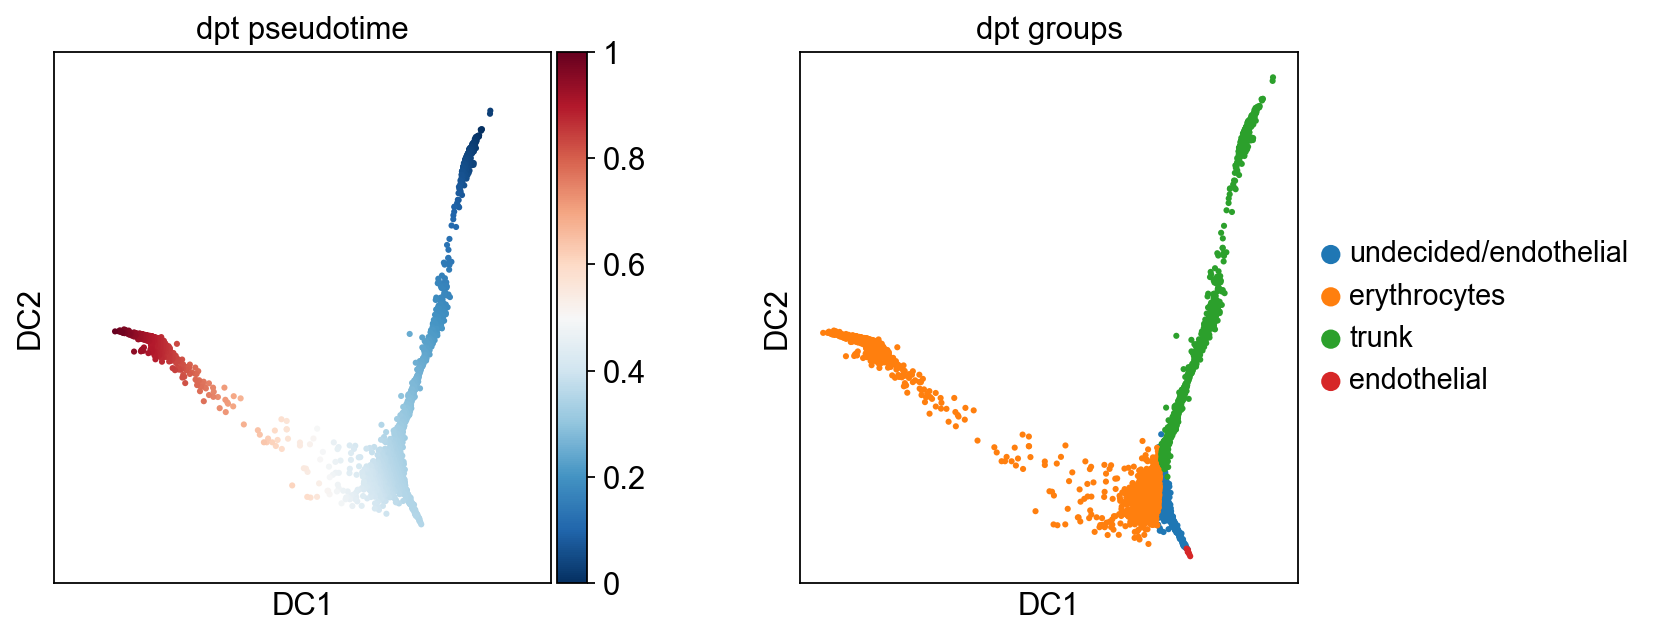

In [10]:
sc.pl.dpt_scatter(adata)

Save the results, for instance, as either as 'hdf5' or 'csv'.

In [11]:
sc.write('moignard15', adata)

Or as csv.

In [12]:
adata.obs.to_csv('./write/annotation.csv')

In [13]:
# To write the full object:
# sc.write('./write/moignard15.csv', adata)